# Real Time Eye Gaze Tracking with Kinect


In [4]:
from PIL import Image
import cv2
import numpy as np
import os
import json
import pandas as pd
import bson
from tqdm import tqdm
from pprint import pprint
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

import sys
sys.path.append('../')

from brspy.export import GazesExport
from brspy.export import MimicsExport
from brspy.export import JointsExport
from brspy.export import JointOrientationsExport
from brspy.export import FacePropertiesExport

from brspy.reader import Session
from brspy.export.utils import *

from devices import Camera

import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## Configuration

In [10]:
markers_path = r'./markers.json'
datasets_path = r"./datasets/07_08_18"
sess_path = os.path.join(datasets_path, '1533638926')
cam_data_path = r'./cam_data.json'

with open(markers_path, 'r') as f:
    markers_db = json.load(f)
    
with open(cam_data_path, 'r') as f:
    cam_data = json.load(f)
    
class HDFace:
    
    LefteyeInnercorner = '210'
    LefteyeOutercorner = '469'
    LefteyeMidtop = '241'
    LefteyeMidbottom = '1104'
    RighteyeInnercorner = '843'
    RighteyeOutercorner = '1117'
    RighteyeMidtop = '731'
    RighteyeMidbottom = '1090'
    LefteyebrowInner = '346'
    LefteyebrowOuter = '140'
    LefteyebrowCenter = '222'
    RighteyebrowInner = '803'
    RighteyebrowOuter = '758'
    RighteyebrowCenter = '849'
    MouthLeftcorner = '91'
    MouthRightcorner = '687'
    MouthUpperlipMidtop = '19'
    MouthUpperlipMidbottom = '1072'
    MouthLowerlipMidtop = '10'
    MouthLowerlipMidbottom = '8'
    NoseTip = '18'
    NoseBottom = '14'
    NoseBottomleft = '156'
    NoseBottomright = '783'
    NoseTop = '24'
    NoseTopleft = '151'
    NoseTopright = '772'
    ForeheadCenter = '28'
    LeftcheekCenter = '412'
    RightcheekCenter = '933'
    Leftcheekbone = '458'
    Rightcheekbone = '674'
    ChinCenter = '4'
    LowerjawLeftend = '1307'
    LowerjawRightend = '1327'
    
    @classmethod
    def items(cls):
        return {attr_name: getattr(cls, attr_name)
                for attr_name in dir(cls) if not attr_name.startswith('__') and not callable(getattr(cls, attr_name))}
    
    @classmethod
    def values(cls):
        return [value for key, value in cls.items().items()]
    
    @classmethod
    def keys(cls):
        return [key for key, value in cls.items().items()]
    
EyeRightCircleIdx = [776,  777,  846,  843,  1098, 
                     1097,  1095,  1096,  1096,  1091, 
                     1090,  1092,  1099,  1094,  1093, 
                     1100,  1101,  1102,  1117,  1071, 
                     1012,  992,  987,  752,  749, 
                     876,  733,  731,  728]
EyeLeftCircleIdx = [210, 316, 187, 153, 121,
                    241, 244, 238, 137, 211,
                    188, 287, 440, 1116, 469,
                    1115, 1114, 1113, 1107, 1106,
                    1112, 1105, 1104, 1103, 1108,
                    1109, 1111, 1110]

hd_all = list(map(str, range(0, 1347)))

avg_eye_radius = 0.007462746808244293

### Utils

In [11]:
from scipy.optimize import minimize


class Intersection:
    
    def __init__(self, cam_point, eye_radius, alpha=0.0001, tol=None):
        
        # model parameters
        self.eye_radius = eye_radius
        self.alpha = alpha
        self.tol = tol
        
        # points in 3d
        self.cam_point = cam_point
        self.eye_center = None
        self.ray_point = None
        
        
    def cost(self, point):
        
        # point must be on sphere surface
        sphere_cost = np.abs(np.sum((point - self.eye_center) ** 2) - (self.eye_radius ** 2))
        
        # point must be on line
        line_eq_components = (point - self.cam_point) / (self.ray_point - self.cam_point)
#         print(sphere_cost)
        line_cost = np.sum(np.abs(np.diff((point - self.cam_point) / (self.ray_point - self.cam_point))))
        
        # to prevent 2 point intersection ambiguity
        regularization = np.linalg.norm(point)
        
        # sum of all costs
        return sphere_cost ** 2 + line_cost ** 2 + sphere_cost * line_cost + self.alpha * regularization
    
    def find(self, eye_center, ray_point, verbose=True):
        
        # assign points
        self.eye_center = eye_center
        self.ray_point = ray_point
        
        # try minimize
        result = minimize(self.cost, x0=self.eye_center - self.ray_point, tol=self.tol)
        
        # print message
        if verbose:
            print(f'Cost: {result.fun:.2e}. ', result.message, sep='')
            
        return result.x
    
    def np_find(self, arr):
        return self.find(eye_center=arr[:3], ray_point=arr[3:], verbose=False)
    
    
def add_dummy_z(arr_2d):
    return np.column_stack((arr_2d, np.full(arr_2d.shape[0], 1))) 

def to_tuple(dct):
    return tuple(int(item) for key, item in dct.items())

def extract_rectangle(img, pt0, pt1):
    return img[pt0[1]:pt1[1], pt0[0]:pt1[0]]

def dict_to_np(dict_data):
    return np.array([value for axis, value in dict_data.items()]).reshape(-1, len(dict_data))

def add_dummy_z(arr_2d):
    if isinstance(arr_2d, dict):
        arr_2d = dict_to_np(arr_2d)
    return np.column_stack((arr_2d, np.full(arr_2d.shape[0], 1))) 

### Cameras 

In [12]:
for cam_name, data_dict in cam_data.items():
    Camera(cam_name, **data_dict)
    
KinectColor = Camera.get('KinectColor')
WebCamera = Camera.get('WebCamera')
InfraredCamera = Camera.get('InfraredCamera')
KinectInfrared = Camera.get('KinectInfrared')

### write markers to session

In [ ]:
def to_json(vector):
    return {axis: value for axis, value in zip('XYZ', vector)}

# choose only wall 0
markers_wall_0 = {key: value for key, value in markers_db.items() if key.split('_')[1] == '0'}
pprint(markers_wall_0)

markers_save = os.path.join(sess_path, 'DataSource', 'cam_101')

try:
    os.mkdir(markers_save)
except:
    pass

counter = 0
for i in range(5):
    for j in range(8):
        marker = markers_wall_0.get(f'wall_{0}_dot_{j+1}')
        if marker:
            file_name = os.path.join(markers_save, str(counter).rjust(5, '0') + '.txt')
            with open(file_name, 'w') as f:
                json.dump(to_json(marker), f)
            counter += 1

## Read dataset

In [13]:
sess = Session(sess_path)

avoid = [
#     'KinectDepth',
#     'KinectInfrared',
#     'KinectBodyIndex',
#     'KinectColor',
#     'KinectBody',
#     'KinectFaceVertices',
#     'GazeEstimation',
#     'WebCamera',
#     'InfraredCamera',
#     'Markers'
]

sess.remove_devices(*avoid)

snapshots = [snapshot for snapshot in sess.snapshots_iterate(40, verbose=True)]

markers = np.array([dict_to_np(snapshot.Markers).flatten() for snapshot in snapshots[:8]])

100%|██████████| 40/40 [00:07<00:00,  5.64it/s]


### analyse snapshot

In [14]:
i = 0
snapshot = snapshots[i]

face_points = np.array([dict_to_np(snapshot.KinectFaceVertices[idx]).flatten() for idx in hd_all])
face_points = face_points * np.array([-1, -1, 1])

pupil_center_2d = dict_to_np(snapshot.ManualPupils['pupilCenterLeft'])

# flip x-coordinate
pupil_center_2d[0, 0] = 1296 - pupil_center_2d[0, 0]

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(PolynomialFeatures(degree=9), Ridge(1e-9))

EyeLeftCircle = InfraredCamera.vectors_to_self(face_points[EyeLeftCircleIdx])

XY = EyeLeftCircle[:, :2]
Z = EyeLeftCircle[:, 2]

pipe.fit(XY, Z)

# x = np.linspace(XY[:, 0].min(), XY[:, 0].max(), 30)
# y = np.linspace(XY[:, 1].min(), XY[:, 1].max(), 30)

# mesh = np.meshgrid(x, y)
# XY_new = np.column_stack((mesh[0].flatten(), mesh[1].flatten()))

pupil_2d = dict_to_np(snapshot.ManualPupils['pupilCenterLeft'])

pupil_2d[0, 0] = 1296 - pupil_2d[0, 0]

roi = np.array([dict_to_np(roi_pt)[0] for roi_pt in snapshot.GazeEstimation['eyeRoiLeft']])
roi[:, 0] = 1296 - roi[:, 0]

relative_pupil_2d = 1 - (pupil_2d - roi[0]) / np.diff(roi, axis=0)

inner = InfraredCamera.vectors_to_self(face_points[int(HDFace.LefteyeInnercorner)].reshape(1, 3)).flatten()
outer = InfraredCamera.vectors_to_self(face_points[int(HDFace.LefteyeOutercorner)].reshape(1, 3)).flatten()
midtop = InfraredCamera.vectors_to_self(face_points[int(HDFace.LefteyeMidtop)].reshape(1, 3)).flatten()
midbot = InfraredCamera.vectors_to_self(face_points[int(HDFace.LefteyeMidbottom)].reshape(1, 3)).flatten()

topinner = np.array([inner[0], midtop[1]])
botouter = np.array([outer[0], midbot[1]])

size_xy = np.abs(topinner - botouter)

pupil_XY = topinner + relative_pupil_2d * size_xy
pupil_3d = np.column_stack((pupil_XY, pipe.predict(pupil_XY)))
pupil_3d = InfraredCamera.vectors_to_origin(pupil_3d)
pupil_3d

array([[ 0.14385742, -0.12115751,  1.43460169]])

In [16]:
T = dict_to_np(snapshot.GazeEstimation['nosePoint'])
R = dict_to_np(snapshot.GazeEstimation['faceGaze'])
faceGaze = np.array([T.flatten(), (T - 4 * R).flatten()]) * np.array([-1, -1, 1])

In [17]:
# show markers
marker_style = dict(size=2, line=dict(color='rgba(217, 217, 217, 0.14)', width=0.5), opacity=0.8)

x_m, y_m, z_m = markers.T
trace_markers = go.Scatter3d(
    x=x_m,
    y=y_m,
    z=z_m,
    text=np.arange(0, 1347),
    mode='markers',
    marker=marker_style
)

x_p, y_p, z_p = pupil_3d.T
trace_pupil = go.Scatter3d(
    x=x_p,
    y=y_p,
    z=z_p,
    text=np.arange(0, 1347),
    mode='markers',
    marker=marker_style
)

# x_eco, y_eco, z_eco = eye_center_3d.T
# trace_eye_center = go.Scatter3d(
#     x=x_eco,
#     y=y_eco,
#     z=z_eco,
#     text=np.arange(0, 1347),
#     mode='markers',
#     marker=marker_style
# )

# face
x_face, y_face, z_face = face_points.T
trace_face = go.Scatter3d(
    x=x_face,
    y=y_face,
    z=z_face,
    text=np.arange(0, 1347),
    mode='markers',
    marker=marker_style
)

# face gaze
x_face_gaze, y_face_gaze, z_face_gaze = faceGaze.T
trace_face_gaze = go.Scatter3d(
    x=x_face_gaze,
    y=y_face_gaze,
    z=z_face_gaze,
    text=np.arange(0, 1347),
#     mode='markers+line',
    marker=marker_style,
    line=dict(width=5)
)

data = [trace_face, trace_pupil, trace_face_gaze]

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple-3d-scatter')

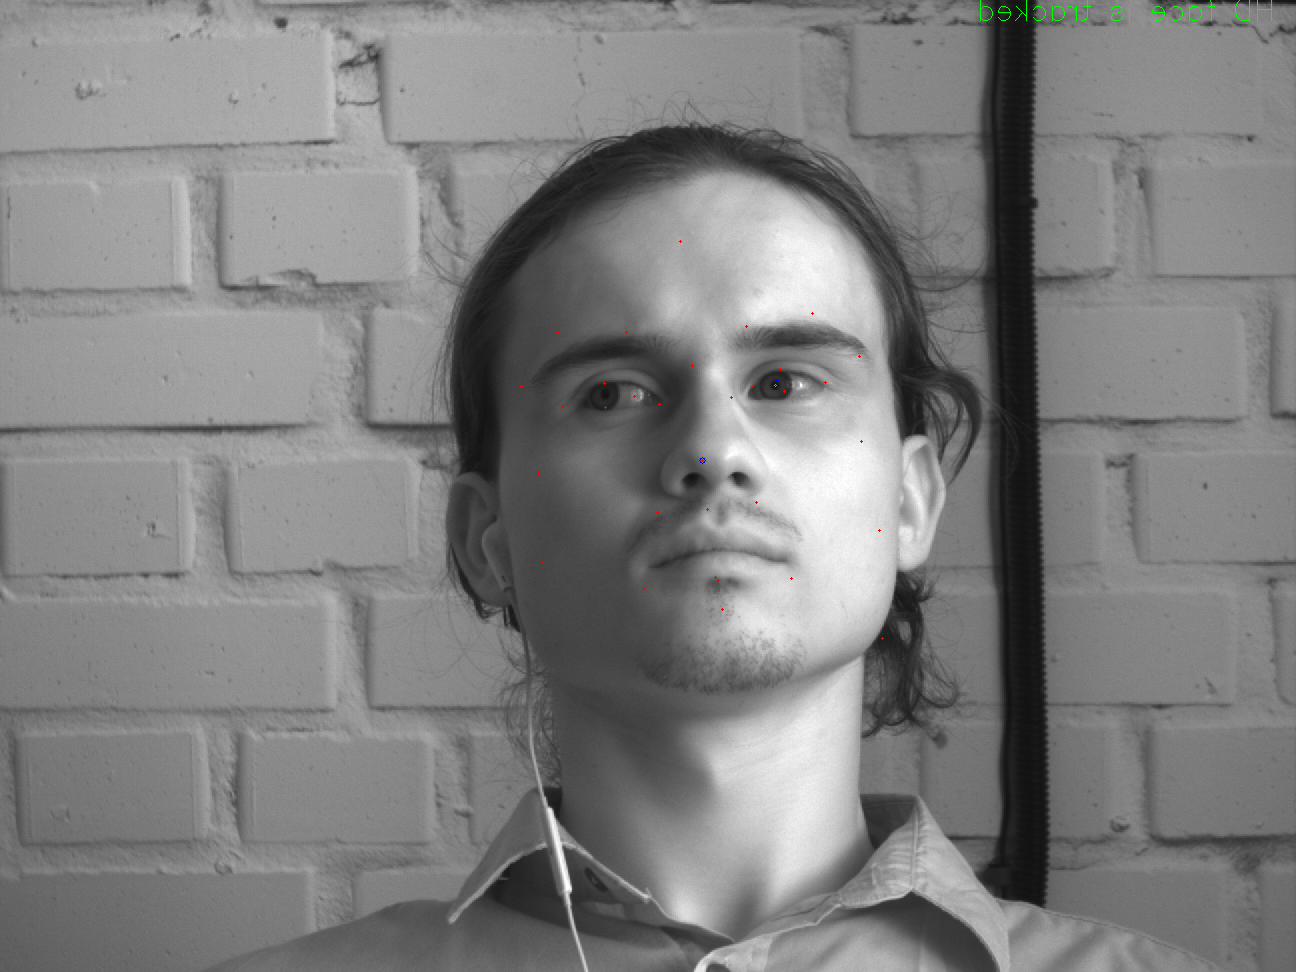

In [188]:
img = np.copy(snapshot.InfraredCamera[:, ::-1, ::-1])
img = (img / img.max() * 255).astype('uint8')

pts_2d = InfraredCamera.project_vectors(face_points[list(map(int, HDFace.values()))]).astype('float64').astype(int)
pupil_test = InfraredCamera.project_vectors(pupil_3d.astype('float64')).astype(int)
nose_2d = InfraredCamera.project_vectors(face_points[int(HDFace.NoseTip)].reshape(1, 3)).astype(int)

for pt_2d in pts_2d:
    cv2.circle(img, tuple(pt_2d), 1, (255, 0, 0), -1)
cv2.circle(img, tuple(pupil_test[0].astype(int)), 1, (0, 0, 255), -1)
cv2.circle(img, tuple(pupil_center_2d[0].astype(int)), 1, (0, 255, 0))
cv2.circle(img, tuple(nose_2d[0].astype(int)), 3, (0, 0, 255), )


Image.fromarray(img)

In [224]:
class PersonCalibration:
    
    default_parameters = np.array([0.0, 0.0, avg_eye_radius, avg_eye_radius/2, -0.03,  0.03, 0.05])
    
    def __init__(self, name='person', parameters=None):
        
        self.name = name
        
        # person parameters
        self.parameters = np.array(parameters) if parameters else self.default_parameters

    @property
    def parameters(self):
        self._parameters = None
    
    @parameters.getter
    def parameters(self):
        return self._parameters
    
    @parameters.setter
    def parameters(self, value):
        self._parameters = value
        
#         print(f'Set parameters to: {value}')
        
        # person parameters links
        self.visual_angles = self.parameters[:2].reshape(1, 2)
        self.eye_radius = self.parameters[2]
        self.cornea_radius = self.parameters[3]
        self.eye_center_head = self.parameters[4:7].reshape(1, 3)
        
    def calculate_eye_center(self, rotation, translation):
        """
        rotation (1, 3)
        translation (1, 3)

        parameters
        eye_center_head (1, 3)
        """
        # (Rodrigues((1, 3)) -> (3, 3))
        rotation_matrix = cv2.Rodrigues(rotation)[0]

        # ((3, 3) @ (3, 1) + (1, 3).T).T -> (1, 3)
        return (rotation_matrix @ self.eye_center_head.T + translation.T).T
    
    def calculate_optical_axis(self, pupil_center, eye_center):
        # ((1, 3) - (1, 3)) / scalar -> optical axis (1, 3)
        return (pupil_center - eye_center) / np.linalg.norm(pupil_center - eye_center)
    
    def calculate_cornea_center(self, eye_center, optical_axis):
        # (1, 3) + scalar * (1, 3) -> (1, 3)
        return eye_center + self.cornea_radius * optical_axis
    
    def calculate_visual_axis(self, optical_axis):
        # (((1, 3) -> (1, 2)) + (1, 2)) -> (1, 3)
        visual_axis = angles2vecs(vecs2angles(optical_axis) + self.visual_angles)
        
        # norm vector
        return visual_axis / np.linalg.norm(visual_axis)
    
    def calculate_eye_geometry(self, pupil_center, rotation, translation):
        
        eye_center = self.calculate_eye_center(rotation, translation)
        optical_axis = self.calculate_optical_axis(pupil_center, eye_center)
        cornea_center = self.calculate_cornea_center(eye_center, optical_axis)
        visual_axis = self.calculate_visual_axis(optical_axis)
        
        return cornea_center, visual_axis
    
    def gaze_direction(self, pupil_center, rotation, translation, coeff=3):
        """
        pupil_center (1, 3)
        rotation (1, 3)
        translation (1, 3)

        parameters
        eye_center_head (1, 3)
        cornea_radius scalar
        """
        cornea_center, visual_axis = self.calculate_eye_geometry(pupil_center, rotation, translation)
        
        return np.array([cornea_center.flatten(), (cornea_center + coeff * visual_axis).flatten()])
    
    def calibrate(self, points, pupil_centers, rotations, translations, alpha=1e-2):
        
        arr = np.column_stack((points, pupil_centers, rotations, translations))

        def cost(parameters):
            
            self.parameters = parameters
            
            loss = 0
            
            for s in arr:
                
                point = s[:3].reshape(1, 3)
                pupil_center, rotation, translation = s[3:6].reshape(1, 3), s[6:9].reshape(1, 3), s[9:12].reshape(1, 3)
                
                cornea_center, visual_axis = self.calculate_eye_geometry(pupil_center, rotation, translation)
                
                gaze_vector_true = point - cornea_center
                gaze_vector_true = gaze_vector_true / np.linalg.norm(gaze_vector_true)
                
                loss += np.sum((gaze_vector_true - visual_axis) ** 2) + alpha * np.linalg.norm(self.eye_center_head) ** 2
            
            return loss
        
        constraints = [
            # eye radius
            {'type': 'ineq', 'fun': lambda x: avg_eye_radius * 0.7 - x[2]},
            {'type': 'ineq', 'fun': lambda x: x[2] - avg_eye_radius * 1.3},
            
            # cornea radius
            {'type': 'ineq', 'fun': lambda x: x[2] - x[3]},
            {'type': 'ineq', 'fun': lambda x: x[3] - x[2] / 4},
            
            # visual axis angles
            {'type': 'ineq', 'fun': lambda x: x[0] - np.deg2rad(5)},
            {'type': 'ineq', 'fun': lambda x: np.deg2rad(5) - x[0]},
            {'type': 'ineq', 'fun': lambda x: x[1] - np.deg2rad(5)},
            {'type': 'ineq', 'fun': lambda x: np.deg2rad(5) - x[1]},
            
            # eye center head
            {'type': 'ineq', 'fun': lambda x: abs(x[4]) - 0.2},
            {'type': 'ineq', 'fun': lambda x: x[5] - 0.2},
            {'type': 'ineq', 'fun': lambda x: x[6] - 0.4},
            {'type': 'ineq', 'fun': lambda x: 0.4 - abs(x[4])},
            {'type': 'ineq', 'fun': lambda x: 0.4 - x[5]},
            {'type': 'ineq', 'fun': lambda x: 0.6 - x[6]},
            
        ]
        minimized = minimize(cost, x0=self.parameters, constraints=constraints, method='SLSQP')
        
        return minimized
        

In [225]:
markers, pupil_centers, rotations, translations = [], [], [], []

frames = []
for snapshot in snapshots:
    
    face_points = np.array([dict_to_np(snapshot.KinectFaceVertices[idx]).flatten() for idx in hd_all])
    face_points = face_points * np.array([-1, -1, 1])

    pupil_center_2d = dict_to_np(snapshot.ManualPupils['pupilCenterLeft'])

    # flip x-coordinate
    pupil_center_2d[0, 0] = 1296 - pupil_center_2d[0, 0]
    
    pipe = make_pipeline(PolynomialFeatures(degree=9), Ridge(1e-9))

    EyeLeftCircle = InfraredCamera.vectors_to_self(face_points[EyeLeftCircleIdx])

    XY = EyeLeftCircle[:, :2]
    Z = EyeLeftCircle[:, 2]

    pipe.fit(XY, Z)

    # x = np.linspace(XY[:, 0].min(), XY[:, 0].max(), 30)
    # y = np.linspace(XY[:, 1].min(), XY[:, 1].max(), 30)

    # mesh = np.meshgrid(x, y)
    # XY_new = np.column_stack((mesh[0].flatten(), mesh[1].flatten()))

    pupil_2d = dict_to_np(snapshot.ManualPupils['pupilCenterLeft'])

    pupil_2d[0, 0] = 1296 - pupil_2d[0, 0]

    roi = np.array([dict_to_np(roi_pt)[0] for roi_pt in snapshot.GazeEstimation['eyeRoiLeft']])
    roi[:, 0] = 1296 - roi[:, 0]

    relative_pupil_2d = 1 - (pupil_2d - roi[0]) / np.diff(roi, axis=0)

    inner = InfraredCamera.vectors_to_self(face_points[int(HDFace.LefteyeInnercorner)].reshape(1, 3)).flatten()
    outer = InfraredCamera.vectors_to_self(face_points[int(HDFace.LefteyeOutercorner)].reshape(1, 3)).flatten()
    midtop = InfraredCamera.vectors_to_self(face_points[int(HDFace.LefteyeMidtop)].reshape(1, 3)).flatten()
    midbot = InfraredCamera.vectors_to_self(face_points[int(HDFace.LefteyeMidbottom)].reshape(1, 3)).flatten()

    topinner = np.array([inner[0], midtop[1]])
    botouter = np.array([outer[0], midbot[1]])

    size_xy = np.abs(topinner - botouter)

    pupil_XY = topinner + relative_pupil_2d * size_xy
    pupil_3d = np.column_stack((pupil_XY, pipe.predict(pupil_XY)))
    
    pupil_center = InfraredCamera.vectors_to_origin(pupil_3d).flatten()
    translation = dict_to_np(snapshot.GazeEstimation['nosePoint']).flatten()
    rotation = dict_to_np(snapshot.GazeEstimation['faceGaze']).flatten()
    
    # append
    pupil_centers.append(pupil_center)
    rotations.append(rotation)
    translations.append(translation)
    markers.append(dict_to_np(snapshot.Markers).flatten())
    
    # show markers
    marker_style = dict(size=2, line=dict(color='rgba(217, 217, 217, 0.14)', width=0.5), opacity=0.8)

    x_m, y_m, z_m = markers.T
    trace_markers = go.Scatter3d(
        x=x_m,
        y=y_m,
        z=z_m,
        text=np.arange(0, 1347),
        mode='markers',
        marker=marker_style
    )

    x_p, y_p, z_p = pupil_3d.T
    trace_pupil = go.Scatter3d(
        x=x_p,
        y=y_p,
        z=z_p,
        text=np.arange(0, 1347),
        mode='markers',
        marker=marker_style
    )

    # x_eco, y_eco, z_eco = eye_center_3d.T
    # trace_eye_center = go.Scatter3d(
    #     x=x_eco,
    #     y=y_eco,
    #     z=z_eco,
    #     text=np.arange(0, 1347),
    #     mode='markers',
    #     marker=marker_style
    # )

    # face
    x_face, y_face, z_face = face_points.T
    trace_face = go.Scatter3d(
        x=x_face,
        y=y_face,
        z=z_face,
        text=np.arange(0, 1347),
        mode='markers',
        marker=marker_style
    )

    # face gaze
    x_face_gaze, y_face_gaze, z_face_gaze = faceGaze.T
    trace_face_gaze = go.Scatter3d(
        x=x_face_gaze,
        y=y_face_gaze,
        z=z_face_gaze,
        text=np.arange(0, 1347),
    #     mode='markers+line',
        marker=marker_style,
        line=dict(width=5)
    )

    data = [trace_face, trace_pupil, trace_face_gaze]

    layout = go.Layout(
        margin=dict(l=0, r=0, b=0, t=0)
    )
    fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple-3d-scatter')
    
pupil_centers = np.array(pupil_centers)
rotations = np.array(rotations)
translations = np.array(translations)
markers = np.array(markers)

In [228]:
p = PersonCalibration()

p.calibrate(markers, pupil_centers, rotations, translations, alpha=0)

     fun: 11.967818004880781
     jac: array([-23.80902433,  22.93545914,   0.        ,   4.97210479,
       -18.88654268,  19.36681521, -30.45115435])
 message: 'Optimization terminated successfully.'
    nfev: 109
     nit: 12
    njev: 8
  status: 0
 success: True
       x: array([ 0.08732298,  0.08726646,  0.01318683,  0.00329671, -0.02992252,
        0.19913519,  0.6       ])

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

X = np.column_stack(rotation, translation)